In [1]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: Error requiring `StaticArrays` from `ArrayInterface`
│   exception = (ErrorException("too many parameters for type"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000068f84117, Ptr{Nothing} @0x0000000068ff06a9, Ptr{Nothing} @0x000000006901236c, Ptr{Nothing} @0x0000000069012031, Ptr{Nothing} @0x0000000069012b40, Ptr{Nothing} @0x0000000069013515, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 82, Ptr{Nothing} @0x0000000069030c9d, Ptr{Nothing} @0x000000006903241a, Ptr{Nothing} @0x000000001a320bef, Ptr{Nothing} @0x000000001a320c13, Ptr{Nothing} @0x000000001a306531, Ptr{Nothing} @0x000000001a320b3a, Ptr{Nothing} @0x000000001a320b63, Ptr{Nothing} @0x000000001a305e98, Ptr{Nothing} @0x000000001a320aa1, Ptr{Nothing} @0x000000001a320ad3, Ptr{Nothing} @0x000000001a301a8e, Ptr{Nothing} @0x000000001a3089f4, Ptr{Nothing} @0x000000001a308d13, Ptr{Nothing} @0x0000000069030130, Ptr{Nothing} @0x0000000069026590, Ptr{Nothing} @0x000000001a26a107, Ptr{No

In [2]:
using Plots
gr()  

Plots.GRBackend()

## thickness
### test liquid h and vapor h in a one-loop OHP heating problem-with no dynamics
### plate temperature:  constant uniform 296 K, tube initial temperature uniform 295 K 

### conduction only

# Properies

### Earth property

In [3]:
g = 9.8

9.8

### Solid Physical parameters

In [4]:
ρₛ = 2730; # density
# cₛ  = 8.97e02; # specific heat
cₛ  = 8.93e02; # specific heat
# kₛ  = 1.67e02; # heat conductivity
kₛ  = 1.93e02; # heat conductivity
# d = 2e-3;
plate_d = 1.5e-3;  # plate thickness
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.0015)

### Fluid Physical parameters

In [5]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

In [6]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

αₗ = kₗ/ρₗ/Cpₗ
νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [7]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [8]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0006333345639056725, 0.001520002953373614)

### Set up the evaporator and condenser

In [9]:
inch = 2.54e-2;

In [10]:
power = 40 #watts
total_heater_area = 2.0inch*2.0inch;

In [11]:
qe = power/total_heater_area
hc = 1500.0 *1.5
Tc = Tᵥ

291.2

In [12]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [13]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = 1e-3
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
# one_loop_gap = 1e-2
# x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


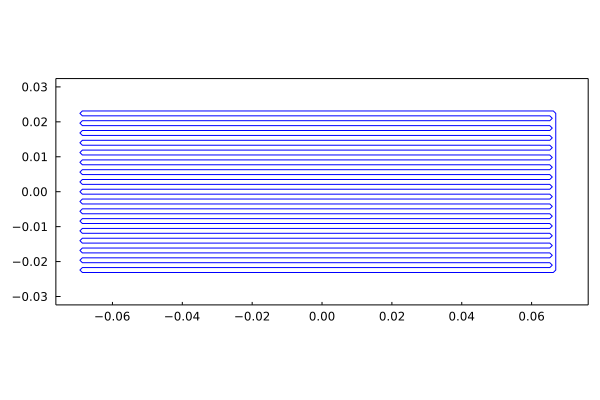

In [14]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [15]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{4877,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [16]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


In [17]:
qtmp = zeros(numpts(ohp));

In [18]:
u0 = newstate(sys)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys);
Tn = temperature(integrator) .+ Tᵥ;

In [19]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


In [20]:
num = 100
ΔN = 100


Thist=[]

@time for i = 1:num
    Tn = ADI_timemarching!(Tn,sys,Δt)
    
    if mod(i,ΔN) == 0
        push!(Thist,deepcopy(Tn))
    end
end

  2.848315 seconds (2.74 M allocations: 1.187 GiB, 7.97% gc time)


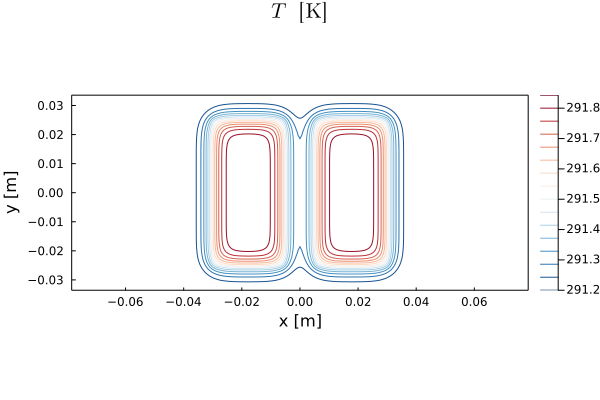

In [21]:
plot(Tn,sys.grid,legend=true,color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

# OHP inner part

### Tube geometries

In [22]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

true

In [23]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,g,closedornot);

### Liquid

In [24]:
Nu = 4.36
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

469.15728016589026

In [25]:
X0,realratio = randomXp(L,numofslugs=30,chargeratio=0.45)
# X0 = [(L/2,L/2+L2D)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r);

In [26]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [27]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [28]:
P = 0*zeros(length(X0)) .+ TtoP(Tᵥ);
δ = 0*zeros(length(X0)) .+ 1.0e-5;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(kₗ,P,δ);

### Wall

### nucleate boiling sites

In [29]:
ΔTthres = 1.0; # superheat threshold

In [30]:
    nucleatenum = 256
#     Xstations = sort(rand(nucleatenum).*L);
    Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

256-element LinRange{Float64}:
 0.0,0.0181667,0.0363334,0.0545,…,4.55984,4.578,4.59617,4.61434,4.6325

In [31]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [32]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [33]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [34]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [35]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [36]:
tspan = (0.0, 50.0);
dt_record = tspan[2] /100;
# dt_record = 0.1;

tstep=5e-4

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [37]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ;

In [38]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

In [39]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

In [40]:
@time for t in tspan[1]:tstep:tspan[2]
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
    
    
      for j in 1:N_iter
        currentsys.wall.θarray = temperature_linesource(integrator_plate)
        currentsys = getcurrentsys(integrator_tube.u,currentsys)

        qtmp = sys_to_heatflux(currentsys)
        set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.5000000000000003
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
0.9999999999999453
merged!
merged!
merged!
merged!
merged!
1.4999999999998903
merged!
1.9999999999998352
merged!
merged!
Boiled! on 4.014836425754266 at 2.399999999999969
2.500000000000002
merged!
merged!
3.000000000000169
merged!
Boiled! on 0.45416701648803914 at 3.400000000000303
Boiled! on 0.7266672263808627 at 3.400000000000303
Boiled! on 4.251003274328046 at 3.400000000000303
Boiled! on 4.41450340026374 at 3.400000000000303
3.500000000000336
merged!
Boiled! on 4.014836425754266 at 3.700000000000403
Boiled! on 4.105669829051874 at 3.700000000000403
Boiled! on 4.28733663564709 at 3.700000000000403
merged!
merged!
Boiled! on 0.0545000419785647 at 3.8000000000004364
Boiled! on 0.18166680659521567 at 3.8000000000004364
Boiled! on 0.2180001679142588 at 3.8000000000004364
Boiled! on 0.3270002518713882 at 3.8000000000004364
Boiled! on 0.34516693253090974 at 3.8000000000004364
Boiled! on 0.61

merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
Boiled! on 3.433502644649576 at 6.599999999999062
Boiled! on 3.869502980478094 at 6.599999999999062
Boiled! on 3.978503064435223 at 6.599999999999062
Boiled! on 4.142003190370917 at 6.599999999999062
Boiled! on 4.52350348422087 at 6.599999999999062
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
Boiled! on 0.7266672263808627 at 6.799999999998951
Boiled! on 0.7630005876999058 at 6.799999999998951
Boiled! on 0.8901673523165569 at 6.799999999998951
Boiled! on 0.9991674362736862 at 6.799999999998951
Boiled! on 0.036333361319043134 at 6.8999999999988955
Boiled! on 0.0545000419785647 at 6.8999999999988955
Boiled! on 0.07266672263808627 at 6.8999999999988955
Boiled! on 0.09083340329760783 at 6.8999999999988955
Boiled! on 0.18166680659521567 at 6.8999999999988955
Boiled! on 0.19983348725473724 at 6.8999999999988955
Boiled! on 0.2180001679142588 at 6.8999999999988955
Boiled! o

merged!
merged!
merged!
merged!
merged!
merged!
8.499999999998897
Boiled! on 3.742336215861443 at 8.499999999998897
Boiled! on 3.869502980478094 at 8.499999999998897
Boiled! on 4.105669829051874 at 8.499999999998897
Boiled! on 4.251003274328046 at 8.499999999998897
merged!
merged!
merged!
merged!
merged!
merged!
merged!
Boiled! on 0.2180001679142588 at 8.599999999999019
Boiled! on 0.3270002518713882 at 8.599999999999019
Boiled! on 0.34516693253090974 at 8.599999999999019
Boiled! on 0.36333361319043134 at 8.599999999999019
Boiled! on 0.5813337811046901 at 8.599999999999019
Boiled! on 0.8538339909975137 at 8.599999999999019
Boiled! on 0.9991674362736862 at 8.599999999999019
Boiled! on 1.4351677721022038 at 8.599999999999019
Boiled! on 3.4698360059686193 at 8.599999999999019
Boiled! on 3.978503064435223 at 8.599999999999019
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
Boiled! on 3.1973357960757958 at 8.799999999999

merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
Boiled! on 0.3270002518713882 at 10.100000000000852
Boiled! on 0.45416701648803914 at 10.100000000000852
Boiled! on 0.5813337811046901 at 10.100000000000852
Boiled! on 0.7266672263808627 at 10.100000000000852
Boiled! on 0.7630005876999058 at 10.100000000000852
Boiled! on 0.8538339909975137 at 10.100000000000852
Boiled! on 0.8901673523165569 at 10.100000000000852
Boiled! on 1.0355007975927293 at 10.100000000000852
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
Boiled! on 0.036333361319043134 at 10.200000000000975
Boiled! on 0.0545000419785647 at 10.200000000000975
Boiled! on 0.07266672263808627 at 10.200000000000975
Boiled! on 0.09083340329760783 at 10.200000000000975
Boiled! on 0.18166680659521567 at 10.200000000000975
Boiled! on 0.19983348725473724 at 10.200000000000975
Boiled! on 0.2180001679142588 at 10.200000000000975
Boiled! on 0.3270002518713882 at 10.200000000

merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
Boiled! on 0.09083340329760783 at 11.600000000002685
Boiled! on 0.18166680659521567 at 11.600000000002685
Boiled! on 0.19983348725473724 at 11.600000000002685
Boiled! on 0.2180001679142588 at 11.600000000002685
Boiled! on 0.3088335712118666 at 11.600000000002685
Boiled! on 0.3270002518713882 at 11.600000000002685
Boiled! on 0.34516693253090974 at 11.600000000002685
Boiled! on 0.45416701648803914 at 11.600000000002685
Boiled! on 0.4905003778070823 at 11.600000000002685
Boiled! on 0.8538339909975137 at 11.600000000002685
Boiled! on 0.9991674362736862 at 11.600000000002685
Boiled! on 1.2716676461665097 at 11.600000000002685
Boiled! on 1.4351677721022038 at 11.600000000002685
Boiled! on 3.7060028545423997 at 11.600000000002685
Boiled! on 3.869502980478094 at 11.600000000002685
Boiled! on 4.251003274328046 at 11.600000000002685
Boiled! on 4.378170038944697 at 11.600000000002685
merged!
merged!
merged!
merged!
me

merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
13.000000000004396
merged!
Boiled! on 0.0545000419785647 at 13.000000000004396
Boiled! on 0.2180001679142588 at 13.000000000004396
Boiled! on 3.978503064435223 at 13.000000000004396
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
Boiled! on 0.18166680659521567 at 13.200000000004641
Boiled! on 3.433502644649576 at 13.200000000004641
Boiled! on 3.5970027705852705 at 13.200000000004641
Boiled! on 3.7060028545423997 at 13.200000000004641
Boiled! on 3.8331696191590505 at 13.200000000004641
Boiled! on 4.014836425754266 at 13.200000000004641
Boiled! on 4.142003190370917 at 13.200000000004641
Boiled! on 4.41450340026374 at 13.200000000004641
merged!
merged!
merged!
merged!
Boiled! on 0.07266672263808627 at 13.300000000004763
Boiled! on 0.0908

merged!
merged!
merged!
merged!
Boiled! on 3.433502644649576 at 14.900000000006719
Boiled! on 3.578836089925749 at 14.900000000006719
Boiled! on 3.978503064435223 at 14.900000000006719
Boiled! on 4.142003190370917 at 14.900000000006719
Boiled! on 4.251003274328046 at 14.900000000006719
Boiled! on 4.28733663564709 at 14.900000000006719
Boiled! on 4.378170038944697 at 14.900000000006719
merged!
merged!
merged!
merged!
merged!
merged!
merged!
merged!
15.00000000000684
Boiled! on 0.07266672263808627 at 15.00000000000684
Boiled! on 0.09083340329760783 at 15.00000000000684
Boiled! on 0.2180001679142588 at 15.00000000000684
Boiled! on 4.142003190370917 at 15.00000000000684
Boiled! on 4.251003274328046 at 15.00000000000684
Boiled! on 4.28733663564709 at 15.00000000000684
Boiled! on 4.41450340026374 at 15.00000000000684
Boiled! on 4.52350348422087 at 15.00000000000684
Boiled! on 4.559836845539913 at 15.00000000000684
merged!
merged!
merged!
merged!
merged!
merged!
merged!
Boiled! on 0.181666806

LoadError: [91mInterruptException:[39m

In [41]:
L

4.650670248837521

In [42]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
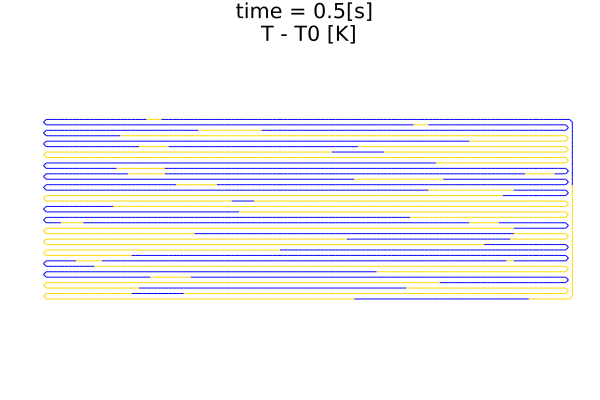

In [43]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

# plot the OHP

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
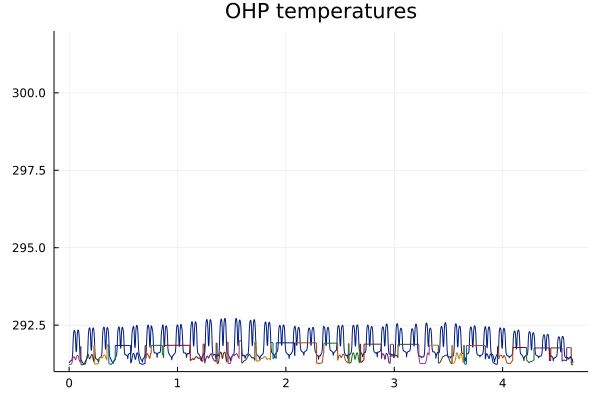

In [44]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T",ylim=(291.0,302.0))
end

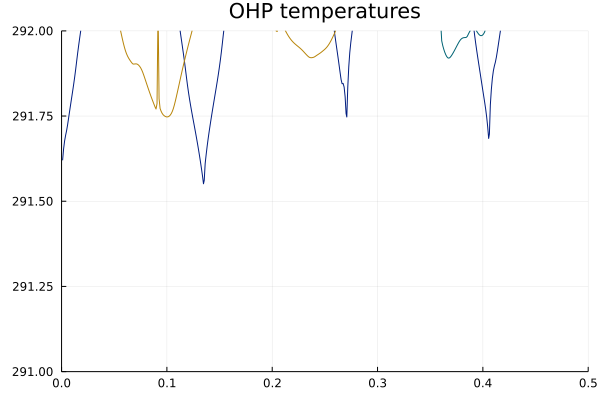

In [45]:
plot(sysfinal[end-30],plottype="T",ylim=(291.0,292.0),xlim=(0.0,0.5))

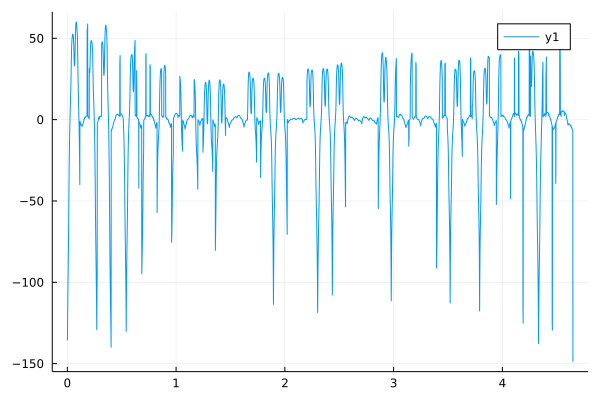

In [46]:
plot(sys.qline[1].arccoord,sys.qline[1].q)

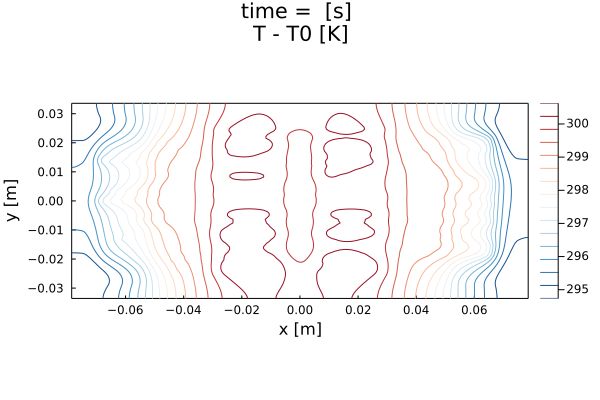

In [47]:
plot(temperature(plate_hist[end-1]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=string("time =  [s] \n",  "T - T0 [K]"))

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
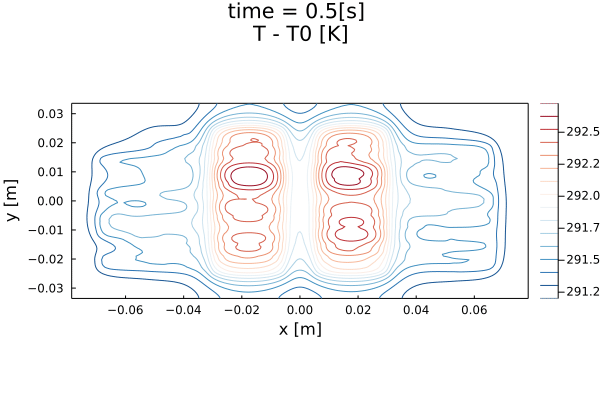

In [48]:
Tmax = maximum(temperature(plate_hist[end-1])[:])
Tmin = 0.0
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1  
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"))
end

In [49]:
# save("plate_H2250_TH1.5_AdiabaticBC.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [50]:
# save("tube_H2250_TH1.5_AdiabaticBC.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

In [51]:
# plate_hist, integrator_plate = load("plate_OHP_dimensional50D0.3TH1_fixed_new.jld2", "plate_hist",  "integrator_plate")
# sys = integrator_plate.p

In [52]:
# tube_hist, integrator_tube = load("tube_OHP_dimensional50D0.3TH1_fixed_new.jld2", "tube_hist",  "integrator_tube")

# sysfinal = []
# for i = 1:length(tube_hist)
#     push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
# end

In [53]:
RTDx,RTD1,RTD4 = load("RTD.jld2","RTDx","RTD1","RTD4")

(0:53, [291.2, 291.2, 291.6, 291.8, 292.1, 292.5, 292.7, 293.1, 293.1, 293.6  …  295.8, 295.7, 295.7, 295.9, 295.9, 295.9, 296.1, 295.7, 295.9, 295.9], [291.2, 292.7, 294.0, 295.0, 295.6, 296.3, 296.8, 297.3, 297.7, 298.1  …  301.2, 301.3, 301.4, 301.4, 301.4, 301.5, 301.4, 301.7, 301.6, 301.6])

In [54]:
x = [-3.0inch,0.0]
y = [0.0,0.0]

X =  VectorData(x,y);

In [55]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [56]:
ghist = []

size(g)
for j = 1:length(g)
    gtemp = []
    for i = 1:length(plate_hist)
        H(g,temperature(plate_hist[i]))
        append!(gtemp,deepcopy(g[j]))
    end
    push!(ghist,deepcopy(gtemp))
end

thist = []
    for i = 1:length(plate_hist)
        append!(thist,plate_hist[i].t)
    end

In [57]:
# ghist = [Tᵥ;Tᵥ]
# for i = 1:length(plate_hist)
#     H(g,temperature(plate_hist[i]))
# #     println(g)
# #     push!(ghist,deepcopy(g))
#     ghist = hcat(ghist,g)
#     append!(thist,plate_hist[i].t)
# end


In [58]:
ghist

2-element Array{Any,1}:
 Any[291.25158624832534, 291.4455602012441, 291.7154035015816, 292.0279306949842, 292.3601159540924, 292.6217020973929, 292.8360484060512, 293.0192535142701, 293.2034271280412, 293.46096155347414  …  295.4214486138533, 295.436340301154, 295.59191748315993, 295.65491034747026, 295.60086775351766, 295.6495058746958, 295.6866586749038, 295.71445250398665, 295.765588862643, 295.8239305516434]
 Any[291.8418255070495, 292.5325510501424, 293.0827833788418, 293.54325930390695, 293.9421286591652, 294.35196887099534, 294.7337211916117, 295.1431468240366, 295.44227936477404, 295.75908864114734  …  298.6493315047131, 298.80905179656736, 298.9178449642545, 299.0314406748335, 299.18595344785274, 299.23868646519884, 299.3984941214242, 299.49422416964455, 299.5948700621936, 299.71384332651905]

In [59]:
thist[1,:]

1-element Array{Any,1}:
 0.5000000000000003

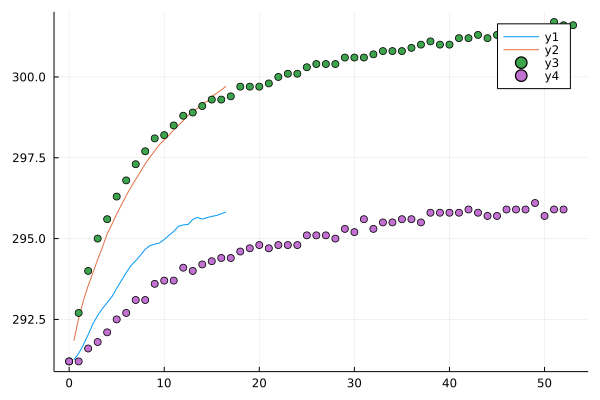

In [60]:
plot(thist,ghist[1])
plot!(thist,ghist[2])
scatter!(RTDx,RTD4)
scatter!(RTDx[1:end-1],RTD1)